In [1]:
from functools import partial
import matplotlib.pyplot as plt

# from readTFRecords import *

# import tensorflow_hub as hub
# from tensorflow.keras.applications import MobileNet

import tensorflow as tf
from tensorflow import keras
import re
import numpy as np
import pandas as pd

from functools import partial

IMAGE_SIZE = (300, 300)
AUTOTUNE = tf.data.experimental.AUTOTUNE
CLASSES = ['0', '1', '2', '3', '4']
NUM_CLASSES = len(CLASSES)

def read_tfrecord(example, labeled=True):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64)
    }

    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = decode_image(example["image"])
    
    if labeled:
        label = tf.cast(example["target"], tf.int32)
        return image, label
    return image

def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32)# / 255.0
    return image
    
    
    
def load_dataset(filenames, labeled=True):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed
    dataset = tf.data.TFRecordDataset(
        filenames
    )  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(
        ignore_order
    )  # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(partial(read_tfrecord, labeled=True), num_parallel_calls=AUTOTUNE)
    # returns a dataset of (image, label) pairs if labeled=True or just images if labeled=False
    return dataset

# One-hot / categorical encoding
# Resize
def input_preprocess(image, label):
    image = tf.image.resize(image, size=IMAGE_SIZE)
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

def get_training_dataset(FILENAMES, BATCH_SIZE=12):
    dataset = load_dataset(FILENAMES, labeled=True)  
    dataset = dataset.map(input_preprocess, num_parallel_calls=AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
#     dataset = dataset.map(cutmix)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def get_validation_dataset(FILENAMES, BATCH_SIZE=12):
    dataset = load_dataset(FILENAMES, labeled=True)
    dataset = dataset.map(input_preprocess, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset



from sklearn.model_selection import train_test_split

# AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = "../input/train_tfrecords"

FILENAMES = tf.io.gfile.glob(GCS_PATH + "/*tfrec")
split_ind = int(0.9 * len(FILENAMES))
# TRAINING_FILENAMES, VALID_FILENAMES = FILENAMES[:split_ind], FILENAMES[split_ind:]

TRAINING_FILENAMES, VALID_FILENAMES = train_test_split(FILENAMES, test_size=0.2, random_state=420)

TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + "../input/test_tfrecords/*tfrec")
print("Train TFRecord Files:", len(TRAINING_FILENAMES))
print("Validation TFRecord Files:", len(VALID_FILENAMES))
print("Test TFRecord Files:", len(TEST_FILENAMES))

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALID_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)

print('Dataset: {} training images, {} validation images, {} (unlabeled) test images'.format(
    NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Train TFRecord Files: 12
Validation TFRecord Files: 4
Test TFRecord Files: 0
Dataset: 16045 training images, 5352 validation images, 0.0 (unlabeled) test images


In [2]:
import efficientnet.keras as eff
from tensorflow.keras.experimental import CosineDecay

In [3]:
BATCH_SIZE = 16
epochs = 12

decay_steps = int(round(NUM_TRAINING_IMAGES/BATCH_SIZE))*epochs
cosine_decay = CosineDecay(initial_learning_rate=1e-4, decay_steps=decay_steps, alpha=0.3)

from keras.backend import sigmoid

class SwishActivation(tf.keras.layers.Activation):
    
    def __init__(self, activation, **kwargs):
        super(SwishActivation, self).__init__(activation, **kwargs)
        self.__name__ = 'swish_act'

def swish_act(x, beta = 1):
    return (x * sigmoid(beta * x))

from keras.utils.generic_utils import get_custom_objects
# from tf.keras.layers import Activation
get_custom_objects().update({'swish_act': SwishActivation(swish_act)})

data_augmentation_layers = tf.keras.Sequential(
    [
#         tf.keras.layers.experimental.preprocessing.RandomCrop(height=512, width=512),
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.25),
        tf.keras.layers.experimental.preprocessing.RandomContrast((0.2,0.2)),
        tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.4, width_factor=0.3)
    ], 
    name="img_augmentation"
)

def buildModel():
    inputs = tf.keras.layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    x = data_augmentation_layers(inputs)
    # model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")
    model = eff.EfficientNetB3(include_top=False, input_tensor=x, weights='noisy-student')


    # Freeze the pretrained weights
    # model.trainable = False

    # Rebuild top
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = tf.keras.layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Dense(512)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(swish_act)(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Dense(256)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(swish_act)(x)

    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    
    return model

In [4]:
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALID_FILENAMES)

train_dataset = get_training_dataset(TRAINING_FILENAMES, BATCH_SIZE)
valid_dataset = get_validation_dataset(VALID_FILENAMES, BATCH_SIZE)

STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALID_STEPS = NUM_VALIDATION_IMAGES // BATCH_SIZE

In [5]:
decay_steps = int(round(NUM_TRAINING_IMAGES/BATCH_SIZE))*epochs
cosine_decay = CosineDecay(initial_learning_rate=1e-4, decay_steps=decay_steps, alpha=0.3)
    
model = buildModel()

checkpoint = tf.keras.callbacks.ModelCheckpoint("EfficientNet_B3.ckpt", 
                                            monitor='val_accuracy', 
                                            verbose=1,
                                            save_best_only=True, 
                                            mode='max', save_freq='epoch',
                                           save_weights_only=True)

# callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(cosine_decay), 
              metrics=["accuracy"])

In [6]:
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
img_augmentation (Sequential)   (None, 300, 300, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 150, 150, 40) 1080        img_augmentation[0][0]           
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 150, 150, 40) 160         stem_conv[0][0]                  
_______________________________________________________________________________________

In [7]:
for image,l in train_dataset.take(1):
    print(image.shape)

(16, 300, 300, 3)


In [8]:
aug_img = data_augmentation_layers(image)

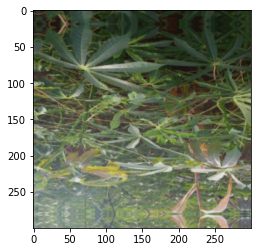

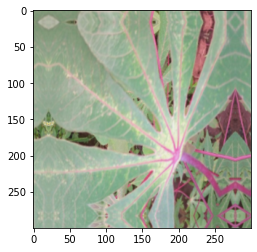

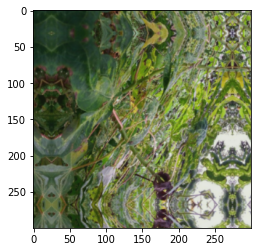

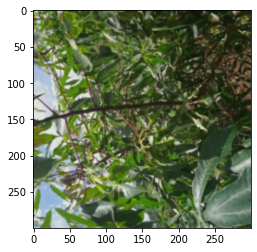

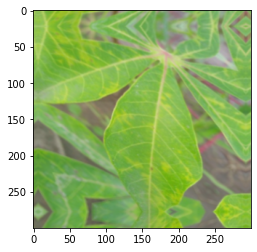

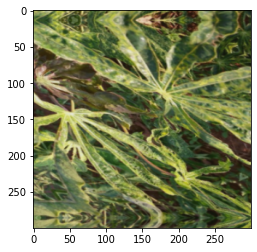

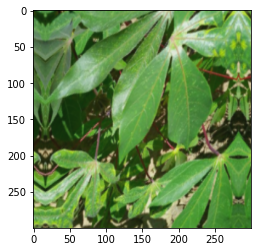

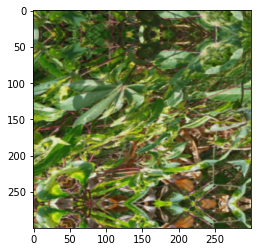

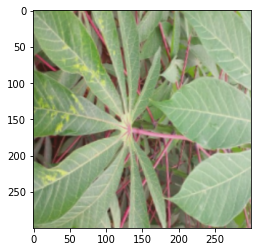

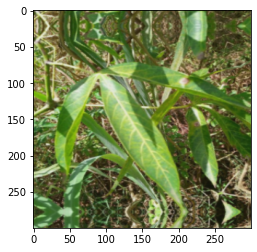

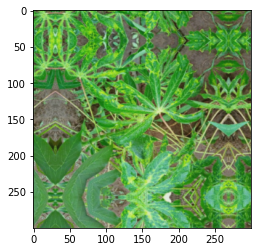

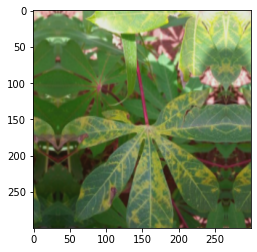

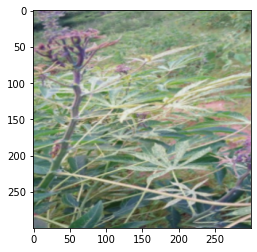

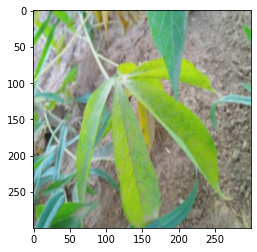

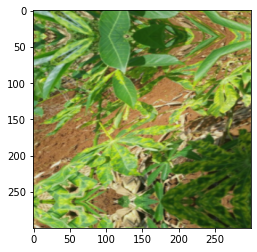

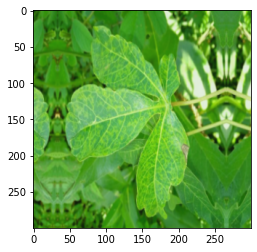

In [9]:
for i in range(BATCH_SIZE):
    plt.imshow(aug_img[i]/255.0)
    plt.show()

In [10]:
history = model.fit(train_dataset, 
                    steps_per_epoch=STEPS_PER_EPOCH, 
                    epochs=25,
                    validation_data=valid_dataset,
                    validation_steps=VALID_STEPS, 
                   callbacks=[checkpoint])

Epoch 1/25
1002/1002 [==============================] - 435s 419ms/step - loss: 1.2082 - accuracy: 0.5425 - val_loss: 0.5483 - val_accuracy: 0.8164

Epoch 00001: val_accuracy improved from -inf to 0.81643, saving model to EfficientNet_B3.ckpt
Epoch 2/25
1002/1002 [==============================] - 419s 418ms/step - loss: 0.6300 - accuracy: 0.7744 - val_loss: 0.4376 - val_accuracy: 0.8574

Epoch 00002: val_accuracy improved from 0.81643 to 0.85741, saving model to EfficientNet_B3.ckpt
Epoch 3/25
1002/1002 [==============================] - 417s 416ms/step - loss: 0.5454 - accuracy: 0.8043 - val_loss: 0.4105 - val_accuracy: 0.8610

Epoch 00003: val_accuracy improved from 0.85741 to 0.86097, saving model to EfficientNet_B3.ckpt
Epoch 4/25
1002/1002 [==============================] - 418s 417ms/step - loss: 0.5127 - accuracy: 0.8180 - val_loss: 0.4397 - val_accuracy: 0.8510

Epoch 00004: val_accuracy did not improve from 0.86097
Epoch 5/25
1002/1002 [==============================] - 419s 

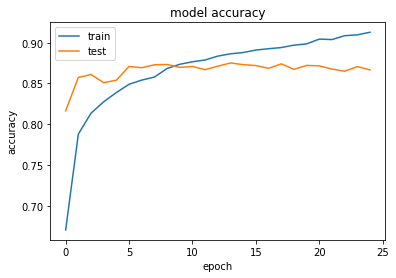

In [11]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()